# Autoencoder + LSTM Model for time series data

This Python code implements an **Autoencoder** using **LSTM** for time series data, where each feature has a different time window interval. Here's an overview of its functionality:

1. **Data Preprocessing**:
   - The code reads multiple CSV files and merges them into a single DataFrame.
   - The user can select relevant features and map specific window sizes to each feature, which applies sliding windows to form time-series sequences.
   - It normalizes the data using **MinMaxScaler** to ensure the values are within a uniform range.

2. **Autoencoder-LSTM Model**:
   - An **Autoencoder** with an LSTM layer is used to compress (encode) and reconstruct (decode) the time series data.
   - The encoder uses **LSTM** units to capture temporal patterns, and the decoder reconstructs the sequence using **RepeatVector** and **TimeDistributed** layers.
   
3. **Hyperparameter Tuning**:
   - **KerasTuner** is used for tuning hyperparameters like the number of LSTM units, latent space dimensions, and learning rate. The best model is selected based on validation loss.
   
4. **Model Training and Evaluation**:
   - The model is trained on time-series data, and the best model is saved after hyperparameter optimization.
   - The model is then used to make predictions on the test data, and the results are evaluated and saved for further analysis.

This approach is useful for anomaly detection, trend discovery, or feature compression in time series data with varying window sizes per feature.

----
----
----
By ali.bavarchee@gmail.com
----
----
----
----

In [31]:
#pip install optuna

In [32]:
#pip install keras_tuner

In [22]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import zipfile
import csv
import os
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import os

from tqdm import tqdm
import time

from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import optuna

from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import RandomSearch

from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

from scipy.signal import find_peaks


seed = 777
np.random.seed(seed)

In [4]:
# Function to generate synthetic EEG signal data for a specific window size
def generate_eeg_signal(timesteps, window_size, frequency=10, noise_level=0.1):
    t = np.linspace(0, window_size, timesteps)
    signal = np.sin(2 * np.pi * frequency * t) + noise_level * np.random.randn(timesteps)
    return signal

# Function to generate time series data with different window sizes for each feature
def create_eeg_dataframe(features, window_size_map, total_timesteps):
    data = {}

    for feature in features:
        window_size = window_size_map[feature]
        timesteps = total_timesteps // window_size

        # Generate EEG signal for each feature based on its specific window size
        signal = generate_eeg_signal(timesteps, window_size)
        repeated_signal = np.tile(signal, total_timesteps // len(signal))[:total_timesteps]  # Repeat the signal to match total timesteps

        data[feature] = repeated_signal

    # Create a pandas DataFrame for the time series data
    df = pd.DataFrame(data)
    df['timestamp'] = pd.date_range(start='2024-01-01', periods=total_timesteps, freq='1S')

    return df

# Function to classify peaks (+1) and troughs (-1)
def classify_peaks_troughs(df, features):
    for feature in features:
        signal = df[feature].values

        # Find the indices of peaks (local maxima)
        peaks, _ = find_peaks(signal)

        # Find the indices of troughs (local minima)
        troughs, _ = find_peaks(-signal)

        # Initialize classification column with zeros
        classification = np.zeros_like(signal)

        # Mark peaks as +1 and troughs as -1
        classification[peaks] = 1
        classification[troughs] = -1

        # Add classification column to DataFrame
        df[f'{feature}_class'] = classification

# Define feature names and corresponding window sizes
features = ['p_1', 'p_2', 'hl_1', 'hl_2', 'p_5', 'hl_5', 'p_10', 'hl_10']
window_size_map = {
    'p_1': 1, 'p_2': 2, 'hl_1': 1, 'hl_2': 2,
    'p_5': 5, 'hl_5': 5, 'p_10': 10, 'hl_10': 10
}

# Generate synthetic EEG data for 1000 timesteps
total_timesteps = 1000
eeg_df = create_eeg_dataframe(features, window_size_map, total_timesteps)

# Classify peaks (+1) and troughs (-1) for each feature
classify_peaks_troughs(eeg_df, features)

# Display the first few rows of the updated EEG data with classifications
print(eeg_df.head())


        p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0 -0.046821 -0.065245 -0.275331 -0.054051 -0.015989 -0.033313 -0.019601   
1 -0.019429  0.180997 -0.027379  0.291665  1.028194  0.952481  0.095837   
2  0.118920  0.523565 -0.129264  0.603835 -0.143205 -0.101295  0.076784   
3  0.116230  0.770977  0.100047  0.639628 -0.982425 -0.993285  0.012857   
4  0.339569  0.886970  0.233362  1.038663  0.103589  0.089626  0.232596   

      hl_10           timestamp  p_1_class  p_2_class  hl_1_class  hl_2_class  \
0  0.010329 2024-01-01 00:00:00        0.0        0.0         0.0         0.0   
1  0.187099 2024-01-01 00:00:01        0.0        0.0         1.0         0.0   
2  0.006169 2024-01-01 00:00:02        1.0        0.0        -1.0         0.0   
3  0.285666 2024-01-01 00:00:03       -1.0        0.0         0.0         0.0   
4  0.309806 2024-01-01 00:00:04        0.0        1.0         0.0         1.0   

   p_5_class  hl_5_class  p_10_class  hl_10_class  
0        0

<ipython-input-4-ac2e040546e7>:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = pd.date_range(start='2024-01-01', periods=total_timesteps, freq='1S')


In [6]:
eeg_df

p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0   -0.046821 -0.065245 -0.275331 -0.054051 -0.015989 -0.033313 -0.019601   
1   -0.019429  0.180997 -0.027379  0.291665  1.028194  0.952481  0.095837   
2    0.118920  0.523565 -0.129264  0.603835 -0.143205 -0.101295  0.076784   
3    0.116230  0.770977  0.100047  0.639628 -0.982425 -0.993285  0.012857   
4    0.339569  0.886970  0.233362  1.038663  0.103589  0.089626  0.232596   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.286766 -0.643720 -0.157976 -0.792320  0.041288 -0.001443 -0.369799   
996 -0.096457 -0.586520 -0.152675 -0.726237  0.878612  0.987288 -0.170795   
997 -0.275835 -0.320629 -0.114636 -0.538906  0.007329 -0.049917 -0.194767   
998 -0.073701 -0.153030  0.002233 -0.286609 -0.889678 -1.187445 -0.058814   
999  0.028615  0.045791 -0.001333 -0.059744  0.185121 -0.074555 -0.027692   

        hl_10           timestamp  p_1_class  p_2_class  hl_1_class  \
0    0.010329 2024-01-01 00:00:00        0.0        0.0         0.0   
1    0.187099 2024-01-01 00:00:01        0.0        0.0         1.0   
2    0.006169 2024-01-01 00:00:02        1.0        0.0        -1.0   
3    0.285666 2024-01-01 00:00:03       -1.0        0.0         0.0   
4    0.309806 2024-01-01 00:00:04        0.0        1.0         0.0   
..        ...                 ...        ...        ...         ...   
995 -0.186042 2024-01-01 00:16:35        0.0        0.0         0.0   
996 -0.147604 2024-01-01 00:16:36        1.0        0.0         0.0   
997  0.052978 2024-01-01 00:16:37       -1.0        0.0         0.0   
998 -0.058580 2024-01-01 00:16:38        0.0        0.0         1.0   
999 -0.032683 2024-01-01 00:16:39        0.0        0.0         0.0   

     hl_2_class  p_5_class  hl_5_class  p_10_class  hl_10_class  
0           0.0        0.0         0.0         0.0          0.0  
1           0.0        1.0         1.0         1.0          1.0  
2           0.0        0.0         0.0         0.0         -1.0  
3           0.0       -1.0        -1.0        -1.0          0.0  
4           1.0        0.0         0.0         1.0          0.0  
..          ...        ...         ...         ...          ...  
995         0.0        0.0         0.0        -1.0          0.0  
996         0.0        1.0         1.0         1.0          0.0  
997         0.0        0.0         0.0        -1.0          1.0  
998         0.0       -1.0        -1.0         0.0         -1.0  
999         0.0        0.0         0.0         0.0          0.0  

[1000 rows x 17 columns]

from matplotlib import pyplot as plt
eeg_df['p_1'].plot(kind='hist', bins=20, title='p_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['p_2'].plot(kind='hist', bins=20, title='p_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['hl_1'].plot(kind='hist', bins=20, title='hl_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['hl_2'].plot(kind='hist', bins=20, title='hl_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df.plot(kind='scatter', x='p_1', y='p_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df.plot(kind='scatter', x='p_2', y='hl_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df.plot(kind='scatter', x='hl_1', y='hl_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eeg_df.plot(kind='scatter', x='hl_2', y='p_5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['hl_1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('hl_1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['hl_2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('hl_2')

from matplotlib import pyplot as plt
eeg_df['p_1'].plot(kind='line', figsize=(8, 4), title='p_1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['p_2'].plot(kind='line', figsize=(8, 4), title='p_2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['hl_1'].plot(kind='line', figsize=(8, 4), title='hl_1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
eeg_df['hl_2'].plot(kind='line', figsize=(8, 4), title='hl_2')
plt.gca().spines[['top', 'right']].set_visible(False)

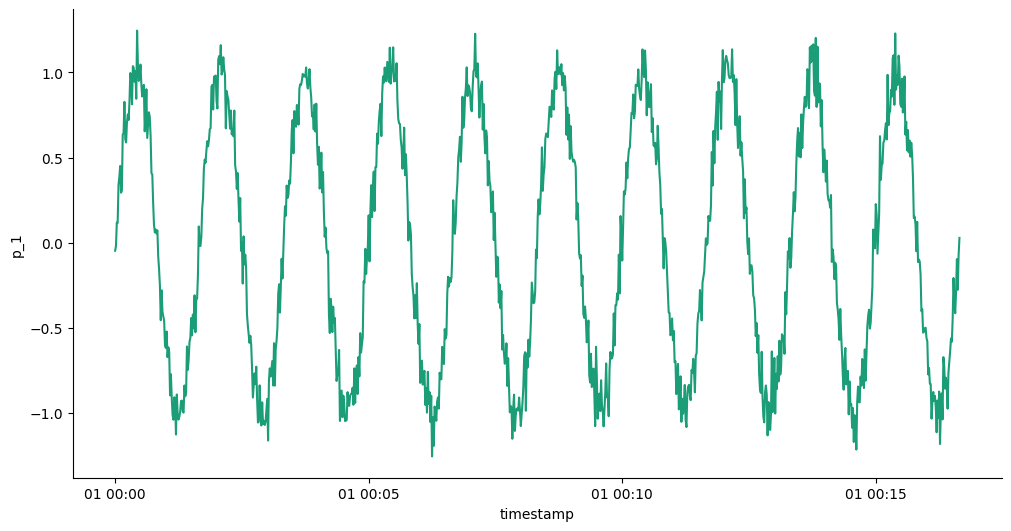

In [7]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_1']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_1')

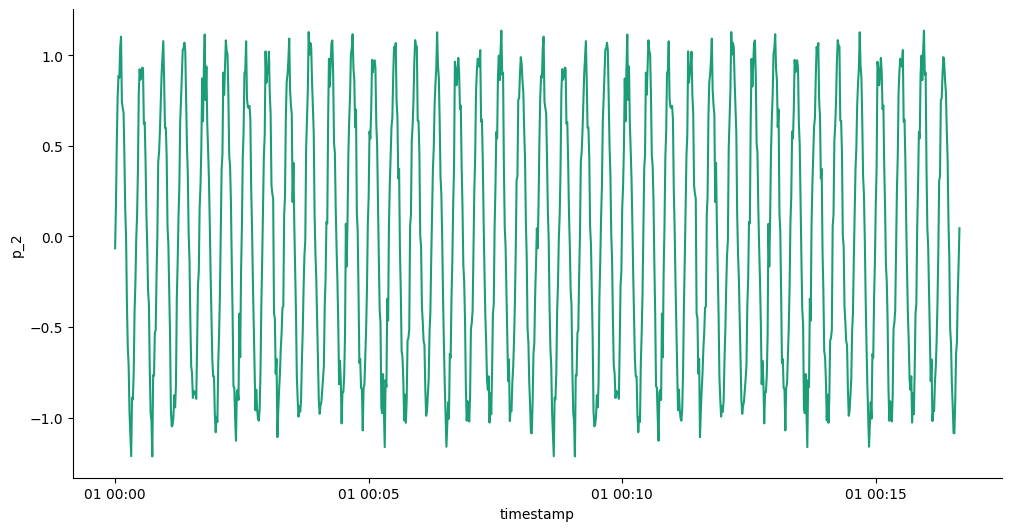

In [8]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_2']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_2')

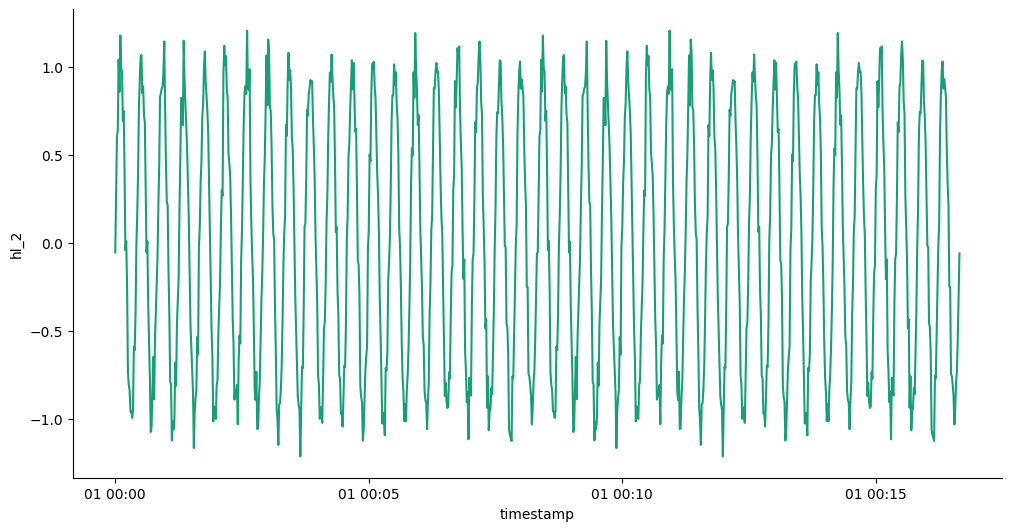

In [12]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['hl_2']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('hl_2')

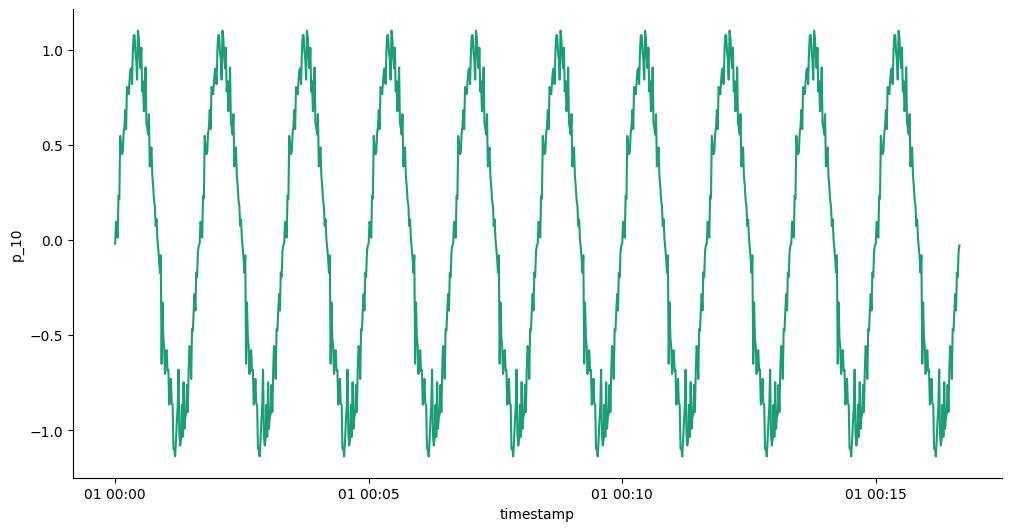

In [13]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_10']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_10')

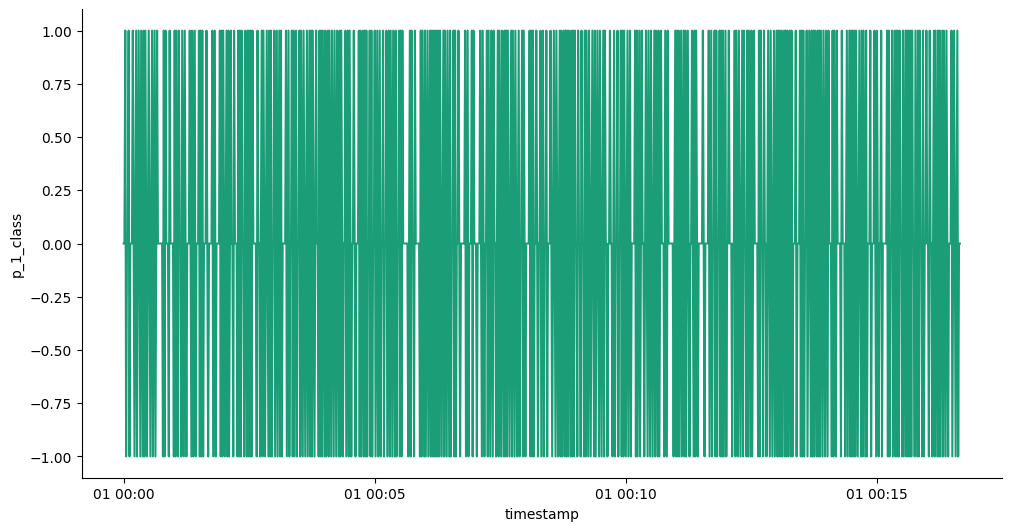

In [14]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['p_1_class']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('p_1_class')

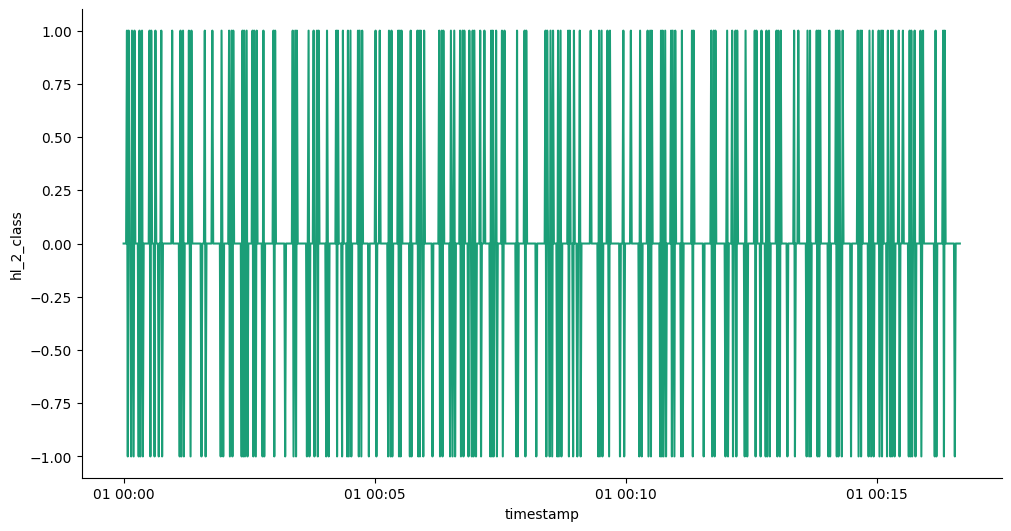

In [16]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['hl_2_class']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eeg_df.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('hl_2_class')

In [5]:
df = eeg_df

def create_dataframe_from_csv(folder_path, column_names=None):
    # Get a list of all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Initialize an empty list to store dataframes
    dataframes = []
    
    # Loop through each CSV file and read it into a dataframe
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        
        # Read the CSV into a dataframe
        df = pd.read_csv(file_path)
        
        # If column_names are provided, select only those columns
        if column_names:
            df = df[column_names]
        
        # Append the dataframe to the list
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    final_df = pd.concat(dataframes, ignore_index=True)
    
    return final_df

How it works==>

folder_path = '/path/to/your/csv/files'

columns_to_keep = ['column1', 'column2', 'column3']

df = create_dataframe_from_csv(folder_path, columns_to_keep)

print(df)

def select_features(dataframe):
    print("Available columns in the DataFrame:")
    print(dataframe.columns.tolist())
    
    selected_columns = []
    
    while True:
        print("\nType the name of the columns you want to select for training (one at a time).")
        print("Type 'done' when finished or 'all' to select all columns.")
        
        user_input = input("Select feature: ")
        
        if user_input == 'done':
            break
        elif user_input == 'all':
            selected_columns = dataframe.columns.tolist()
            break
        elif user_input in dataframe.columns:
            if user_input not in selected_columns:
                selected_columns.append(user_input)
                print(f"'{user_input}' has been added to the selection.")
            else:
                print(f"'{user_input}' is already selected.")
        else:
            print(f"'{user_input}' is not a valid column name. Please try again.")
    
    if not selected_columns:
        print("No features selected. Exiting...")
        return None
    
    selected_df = dataframe[selected_columns]
    return selected_df

do = select_features(df)

features = selected_features_df.columns
features = list(features)

def map_features_to_window_size(features_list):
    # Initialize an empty dictionary to store feature-window size mapping
    window_size_map = {}

    # Loop through each feature and ask the user for a window size
    for feature in features_list:
        while True:
            try:
                # Prompt the user to input a window size for the current feature
                user_input = input(f"Enter the window size for {feature}: ")
                
                # Convert input to integer
                window_size = int(user_input)
                
                # Store the window size in the dictionary
                window_size_map[feature] = window_size
                
                break  # Exit the loop if valid input is provided
            except ValueError:
                print("Invalid input. Please enter an integer.")
    
    return window_size_map

Example usage:
features_list = ['feature_1', 'feature_2', 'feature_3']  # List of feature names
win_size = map_features_to_window_size(features_list)

window_size_map = map_features_to_window_size(features)

In [18]:
target = 'p_1_class'

In [19]:
# Load The DataFrame df
X = df[features].values
y = df[target].values

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Prepare the time-series data (Same as the previous code)
max_window_size = max(window_size_map.values())
X_time_series = []

# Loop through each feature, apply window size, and reshape accordingly
for i, feature in enumerate(features):
    feature_series = X_scaled[:, i]  # Extract the feature series
    window_size = window_size_map[feature]

    # Create sliding windows for this feature
    feature_time_series = np.array([feature_series[j:j + window_size] for j in range(len(feature_series) - window_size + 1)])

    # Pad to make all series have the same length (matching max_window_size)
    if feature_time_series.shape[1] < max_window_size:
        pad_length = max_window_size - feature_time_series.shape[1]
        feature_time_series = np.pad(feature_time_series, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)

    X_time_series.append(feature_time_series)

# Find the minimum number of time steps across all features
min_time_steps = min([ts.shape[0] for ts in X_time_series])

# Truncate all feature time series to the minimum time steps to make them the same length
X_time_series = [ts[:min_time_steps] for ts in X_time_series]

# Stack the features along the last axis
X_time_series = np.stack(X_time_series, axis=-1)

In [21]:
# Define the model builder function for KerasTuner
def build_autoencoder_model(hp):
    latent_dim = hp.Int('latent_dim', min_value=10, max_value=35, step=5)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=1024, step=64)

    inputs = Input(shape=(X_time_series.shape[1], X_time_series.shape[2]))

    # Encoder
    encoded = LSTM(lstm_units, activation='relu')(inputs)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    # Decoder
    decoded = RepeatVector(X_time_series.shape[1])(encoded)
    decoded = LSTM(lstm_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(X_time_series.shape[2]))(decoded)

    # Compile the model
    autoencoder = Model(inputs, decoded)
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder

# Hyperparameter tuning using RandomSearch
tuner = RandomSearch(
    build_autoencoder_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='autoencoder_tuning',
    project_name='autoencoder')

# Run the hyperparameter search
tuner.search(X_time_series, X_time_series, epochs=50, batch_size=64, validation_split=0.4)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss = best_model.evaluate(X_time_series, X_time_series)

# Save the best model and results
best_model.save('best_autoencoder_model.h5')
np.save('scaler.npy', scaler)

# Report the results
print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)
print("Best model evaluation loss: ", loss)


scaler = np.load('scaler.npy', allow_pickle=True).item()
#best_model = load_model('best_autoencoder_model.h5')

X = df[features].values
X_scaled = scaler.transform(X)

# Prepare the time-series data (similar to previous code)
max_window_size = max(window_size_map.values())
X_time_series = []

for i, feature in enumerate(features):
    feature_series = X_scaled[:, i]  # Extract the feature series
    window_size = window_size_map[feature]

    # Create sliding windows for this feature
    feature_time_series = np.array([feature_series[j:j + window_size] for j in range(len(feature_series) - window_size + 1)])

    # Pad to make all series have the same length (matching max_window_size)
    if feature_time_series.shape[1] < max_window_size:
        pad_length = max_window_size - feature_time_series.shape[1]
        feature_time_series = np.pad(feature_time_series, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)

    X_time_series.append(feature_time_series)

# Truncate all feature time series to the minimum time steps
min_time_steps = min([ts.shape[0] for ts in X_time_series])
X_time_series = [ts[:min_time_steps] for ts in X_time_series]

# Stack the features along the last axis
X_time_series = np.stack(X_time_series, axis=-1)

# Make predictions using the best model
X_pred = best_model.predict(X_time_series)

# Reshape predictions and true values to match for visualization
X_pred_reshaped = X_pred.reshape(-1, X_pred.shape[-1])
X_time_series_reshaped = X_time_series.reshape(-1, X_time_series.shape[-1])

# Save predictions vs true values plots for each feature as PDF
for feature_index, feature_name in enumerate(features):
    plt.figure(figsize=(12, 6))
    plt.plot(X_time_series_reshaped[:, feature_index], label='True Values', alpha=0.6)
    plt.plot(X_pred_reshaped[:, feature_index], label='Predicted Values', alpha=0.6)
    plt.title(f'Feature: {feature_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    # Save the plot as a PDF file
    plt.savefig(f'plot_{feature_name}.pdf', format='pdf')
    plt.close()  # Close the figure after saving to avoid memory issues

# Optional: Calculate and print evaluation metrics for the overall model
mse = mean_squared_error(X_time_series_reshaped, X_pred_reshaped)
mae = mean_absolute_error(X_time_series_reshaped, X_pred_reshaped)

print("Evaluation Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Trial 10 Complete [00h 01m 17s]
val_loss: 0.014009355567395687

Best val_loss So Far: 0.006272388389334083
Total elapsed time: 00h 09m 06s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0057


Best hyperparameters:  {'latent_dim': 25, 'lstm_units': 288, 'learning_rate': 0.01}
Best model evaluation loss:  0.005706907249987125
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Evaluation Results:
Mean Squared Error (MSE): 0.0057
Mean Absolute Error (MAE): 0.0328


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


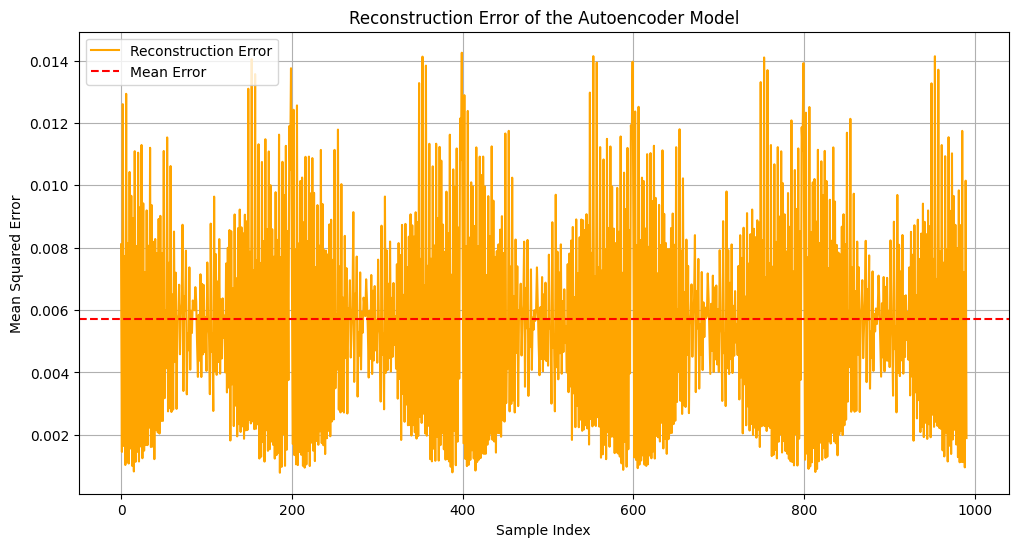

<ipython-input-23-824397a66d6a>:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


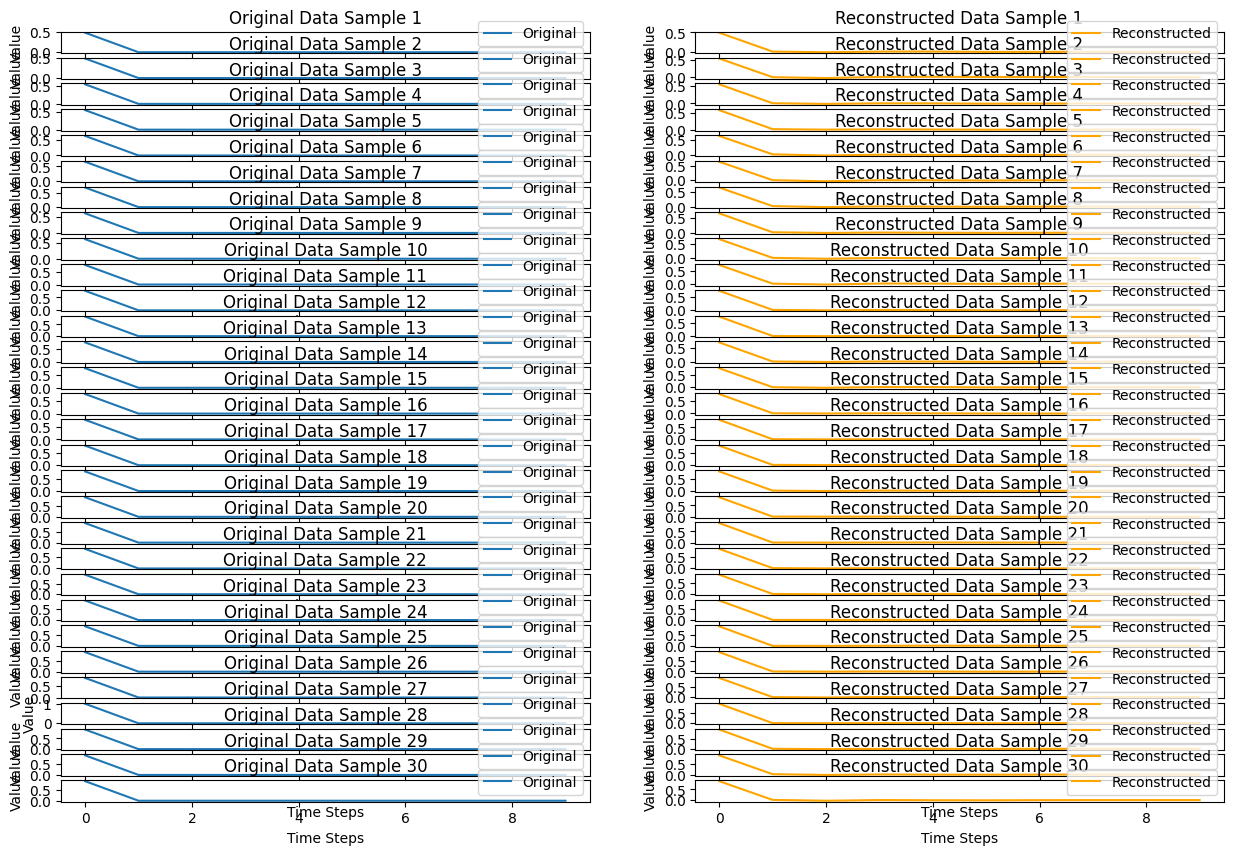

In [23]:
# Load the Best Model
# best_model = tf.keras.models.load_model('best_autoencoder_model.h5')
scaler = np.load('scaler.npy', allow_pickle=True).item()

# Make predictions
X_pred = best_model.predict(X_time_series)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_time_series - X_pred), axis=(1, 2))

# Calculate MSE and R2 score for evaluation
mse = mean_squared_error(X_time_series.reshape(-1), X_pred.reshape(-1))
r2 = r2_score(X_time_series.reshape(-1), X_pred.reshape(-1))


plt.figure(figsize=(12, 6))
plt.plot(reconstruction_error, label='Reconstruction Error', color='orange')
plt.title('Reconstruction Error of the Autoencoder Model')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.axhline(y=np.mean(reconstruction_error), color='r', linestyle='--', label='Mean Error')
plt.legend()
plt.grid()
plt.show()
plt.savefig('reconstruction_error.pdf', format='pdf')
plt.close()


n_samples = 30  # Number of samples to visualize
plt.figure(figsize=(15, 10))

for i in range(n_samples):
    plt.subplot(n_samples, 2, 2 * i + 1)
    plt.plot(X_time_series[i, :, 0], label='Original')
    plt.title(f'Original Data Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(n_samples, 2, 2 * i + 2)
    plt.plot(X_pred[i, :, 0], label='Reconstructed', color='orange')
    plt.title(f'Reconstructed Data Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('original_vs_reconstructed_samples.pdf', format='pdf')
plt.close()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


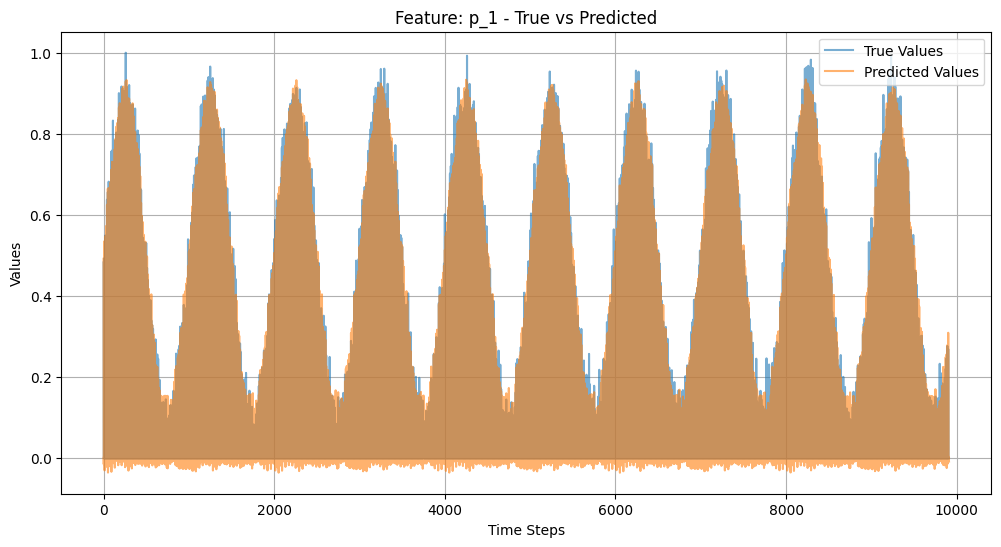

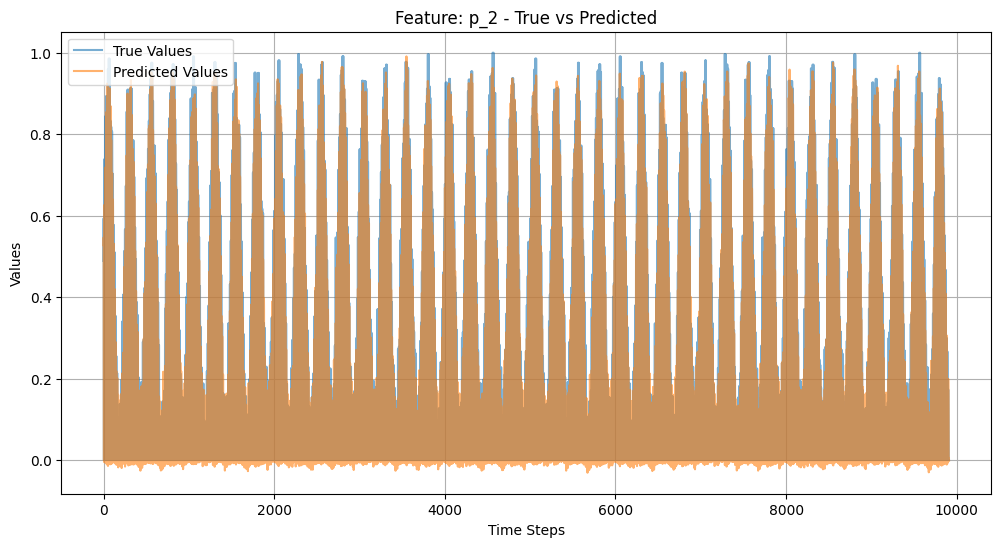

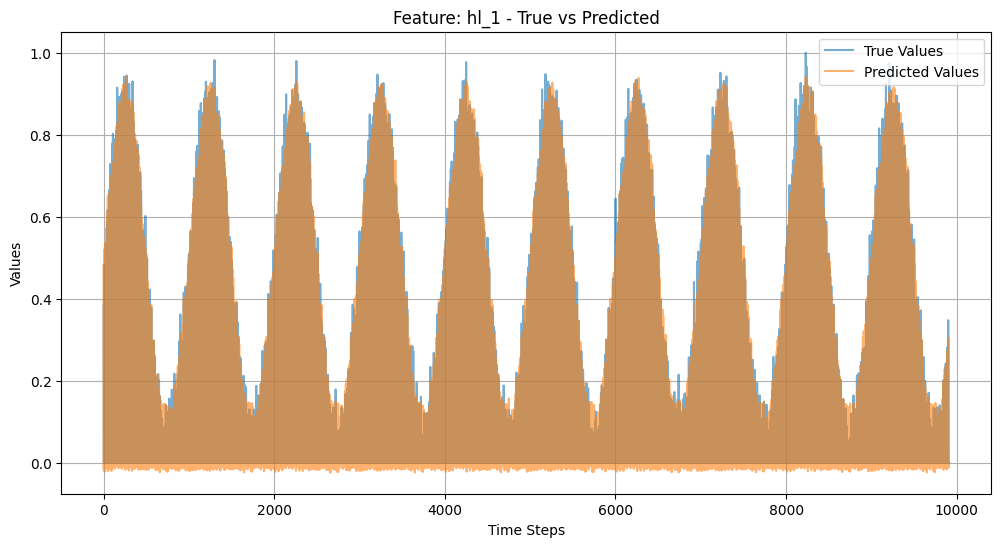

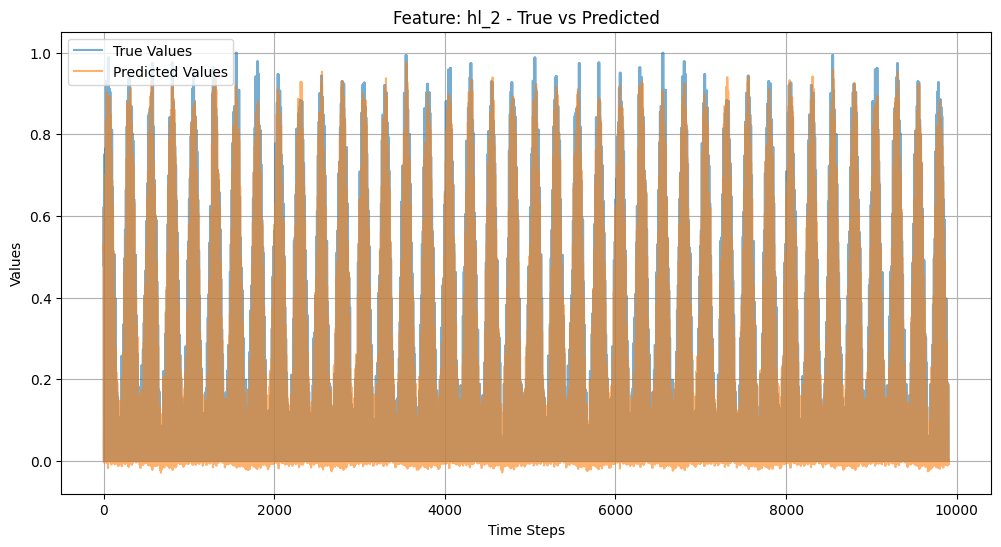

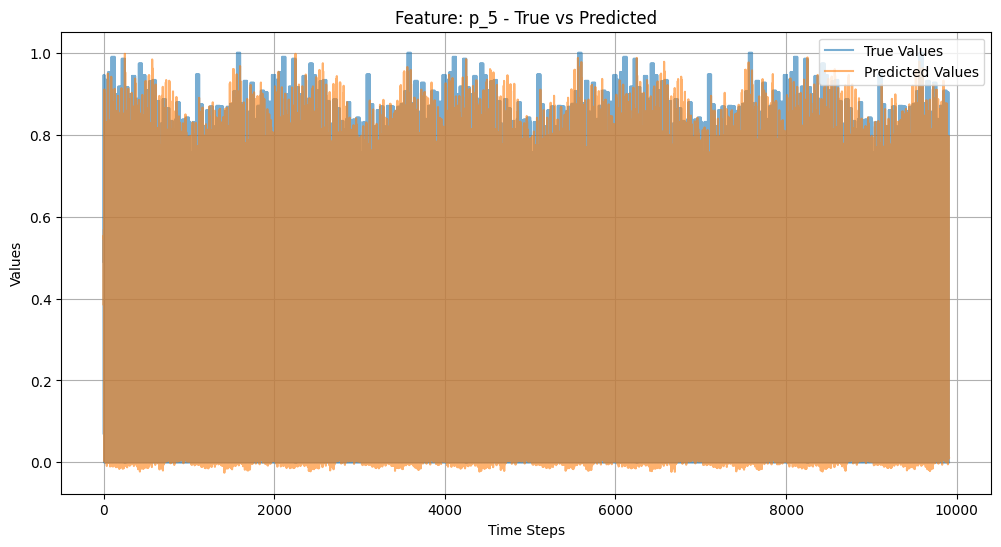

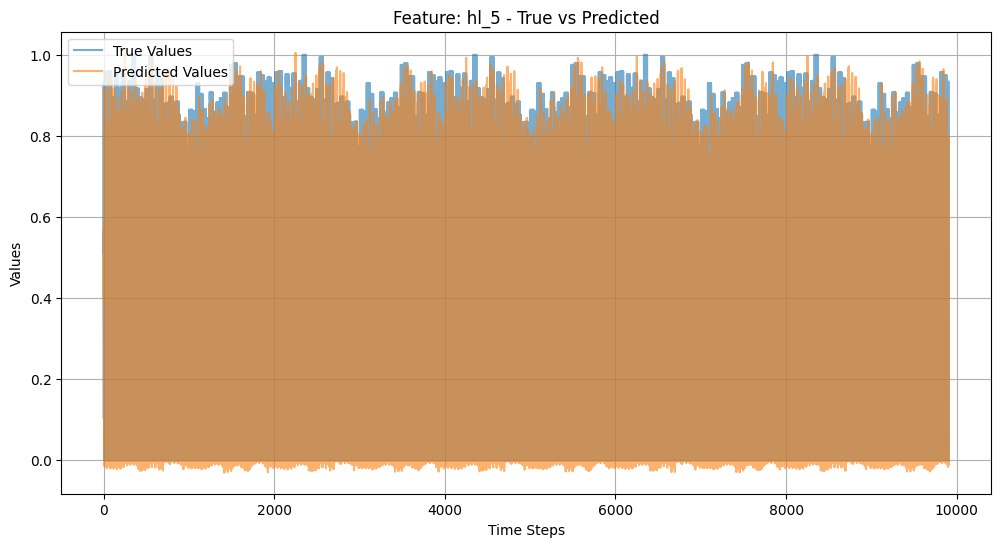

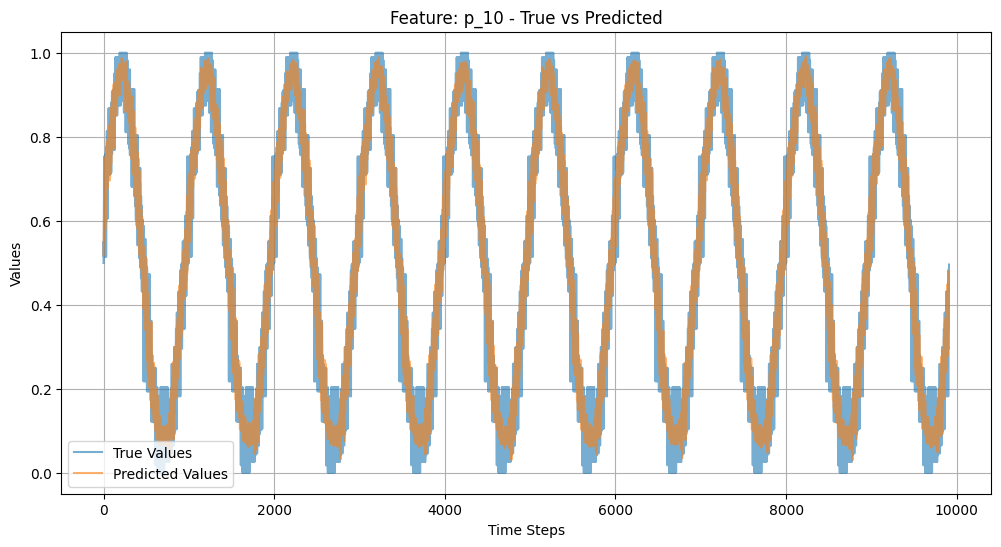

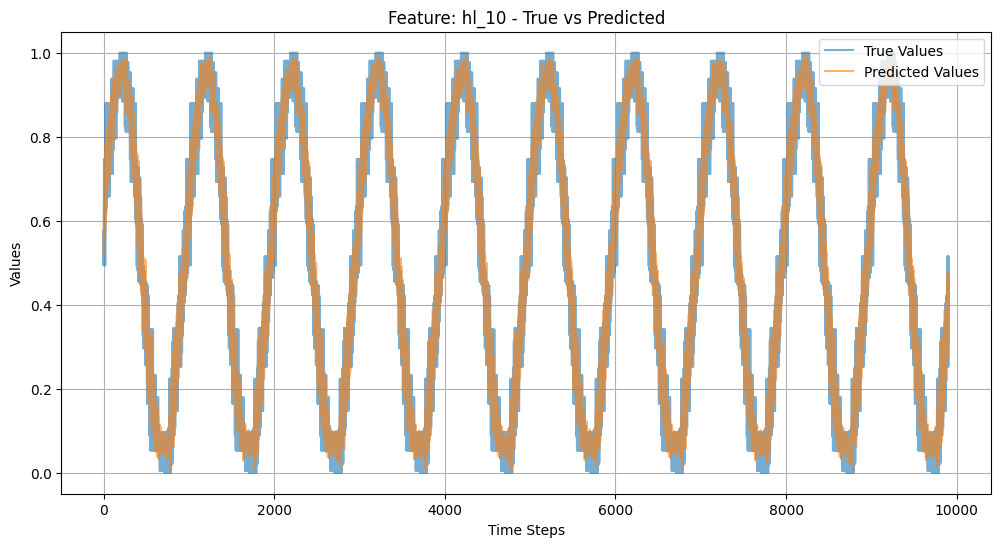

In [24]:
# Make predictions with the autoencoder (for regression!!!)
X_pred = best_model.predict(X_time_series)

# Reshape the predictions and true data for visualization and analysis
X_pred_reshaped = X_pred.reshape(-1, X_pred.shape[-1])
X_time_series_reshaped = X_time_series.reshape(-1, X_time_series.shape[-1])

# Plot True Data vs Predicted Data for Each Feature
for feature_index, feature_name in enumerate(features):
    plt.figure(figsize=(12, 6))
    plt.plot(X_time_series_reshaped[:, feature_index], label='True Values', alpha=0.6)
    plt.plot(X_pred_reshaped[:, feature_index], label='Predicted Values', alpha=0.6)
    plt.title(f'Feature: {feature_name} - True vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the plot as PDF
    plt.savefig(f'plot_{feature_name}_true_vs_pred.pdf', format='pdf')
    plt.close()  # Close the figure to save memory


In [25]:
# Mean Squared Error and R² score for evaluation
mse = mean_squared_error(X_time_series_reshaped, X_pred_reshaped)
mae = mean_absolute_error(X_time_series_reshaped, X_pred_reshaped)
r2 = r2_score(X_time_series_reshaped, X_pred_reshaped)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.0057
Mean Absolute Error (MAE): 0.0328
R² Score: 0.9454


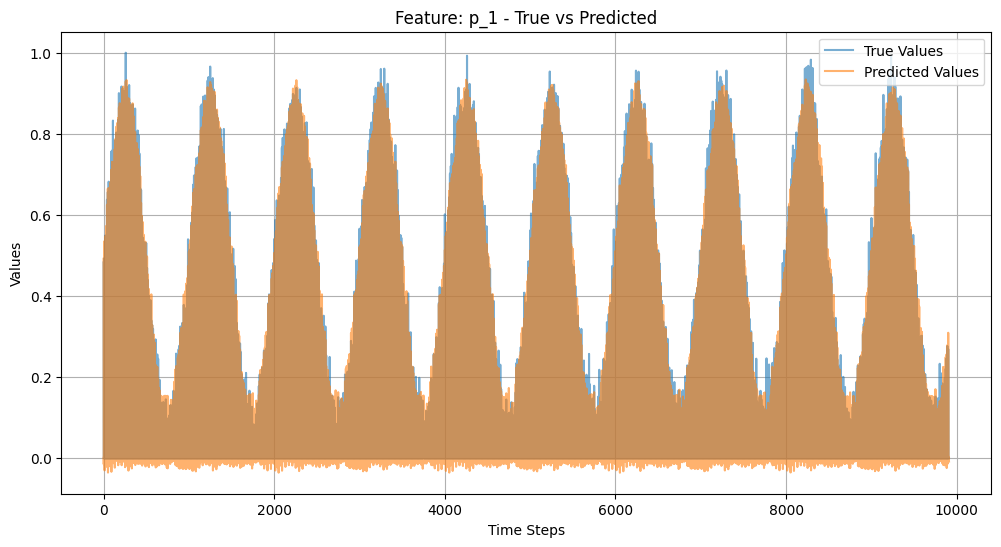

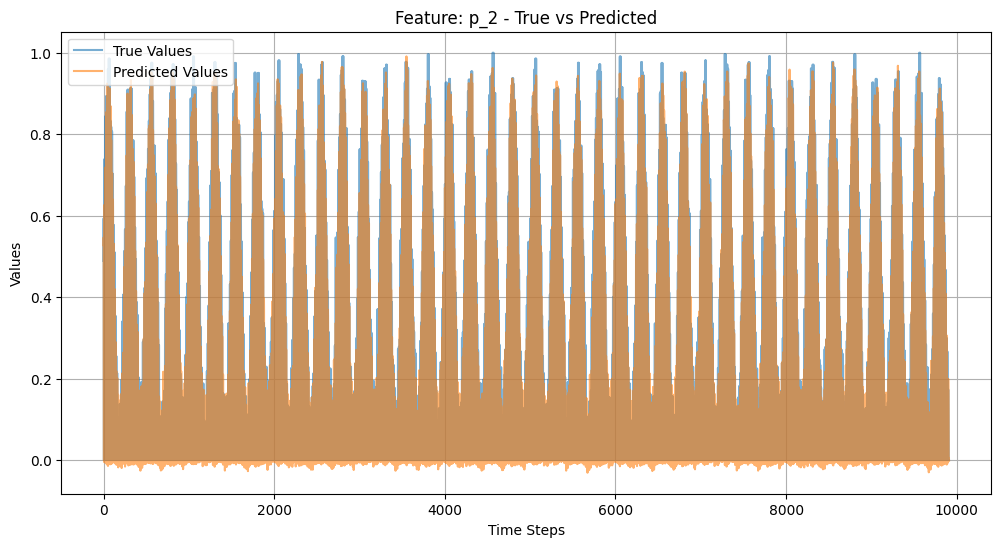

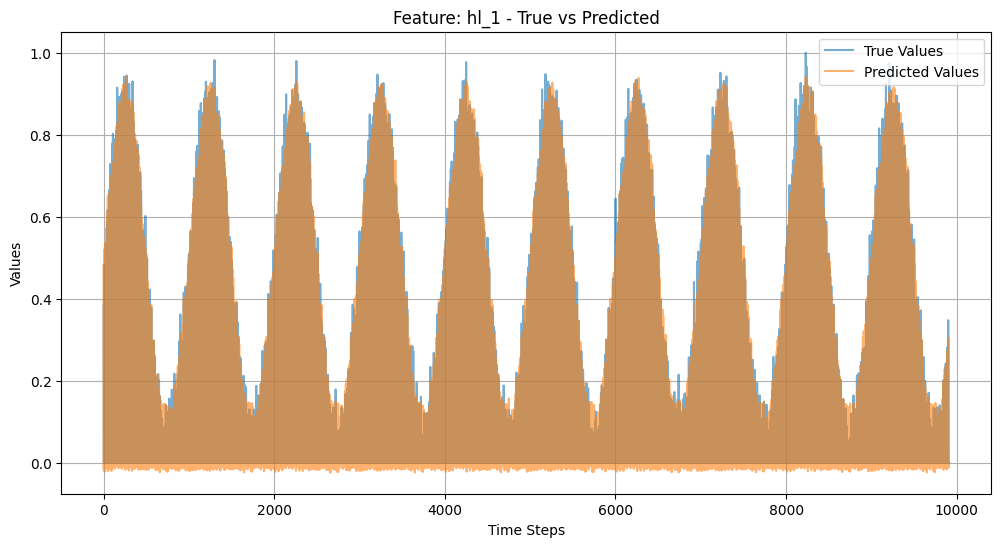

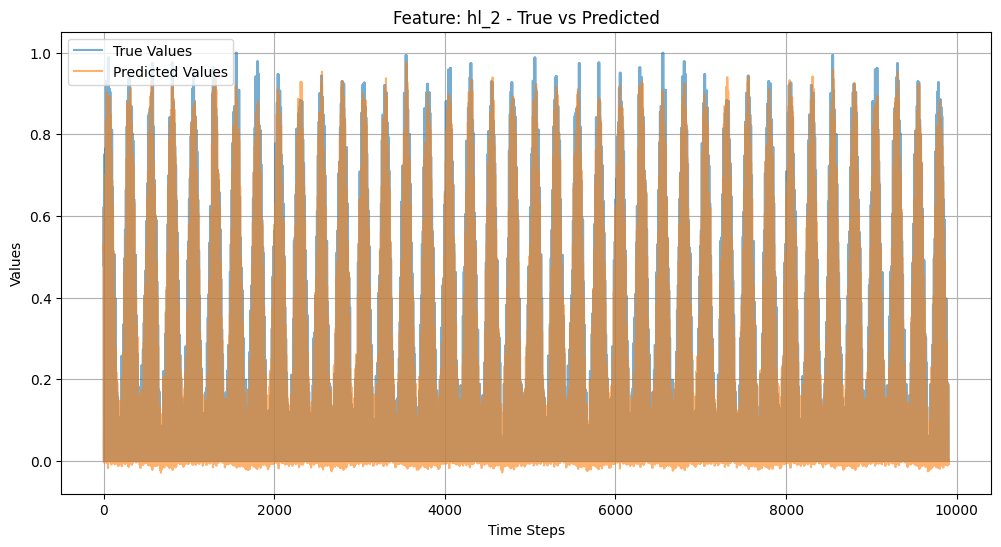

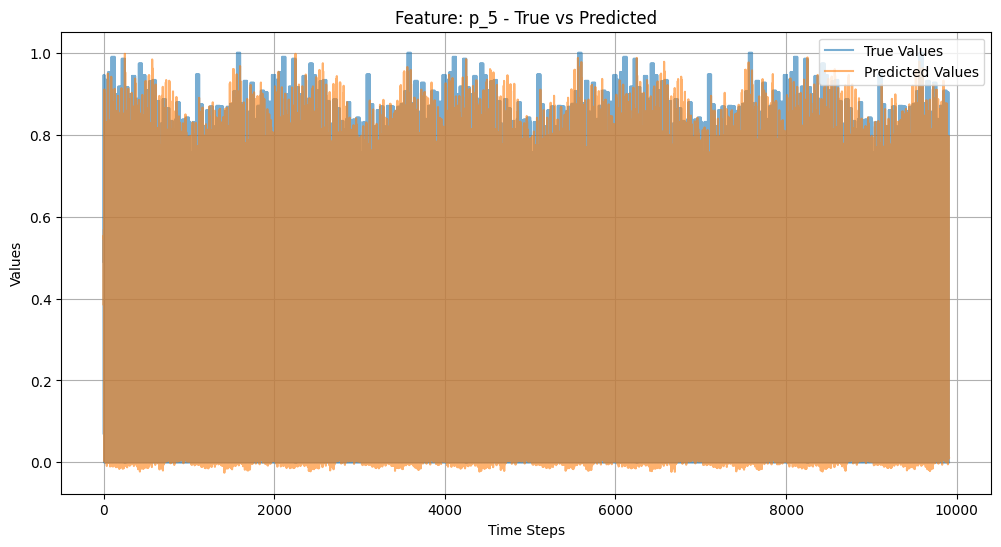

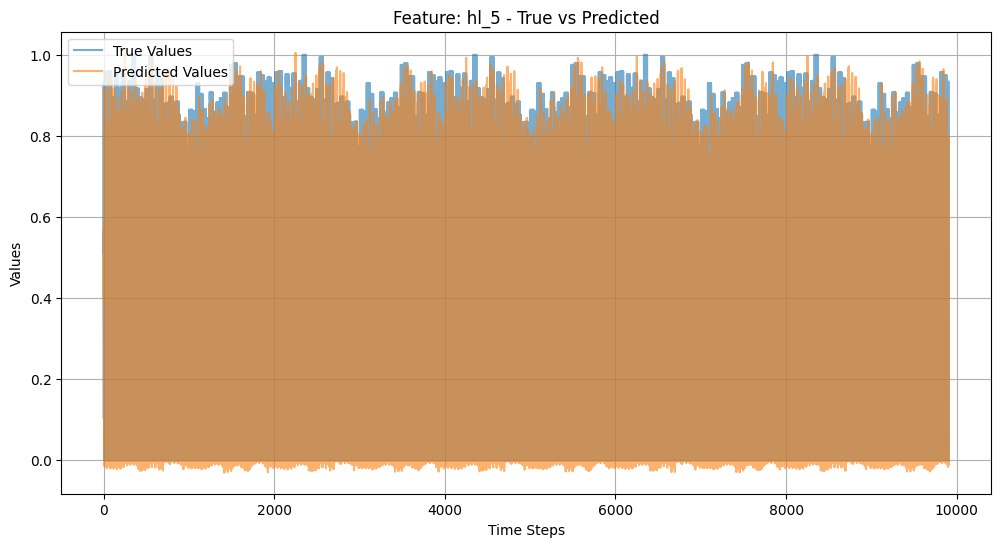

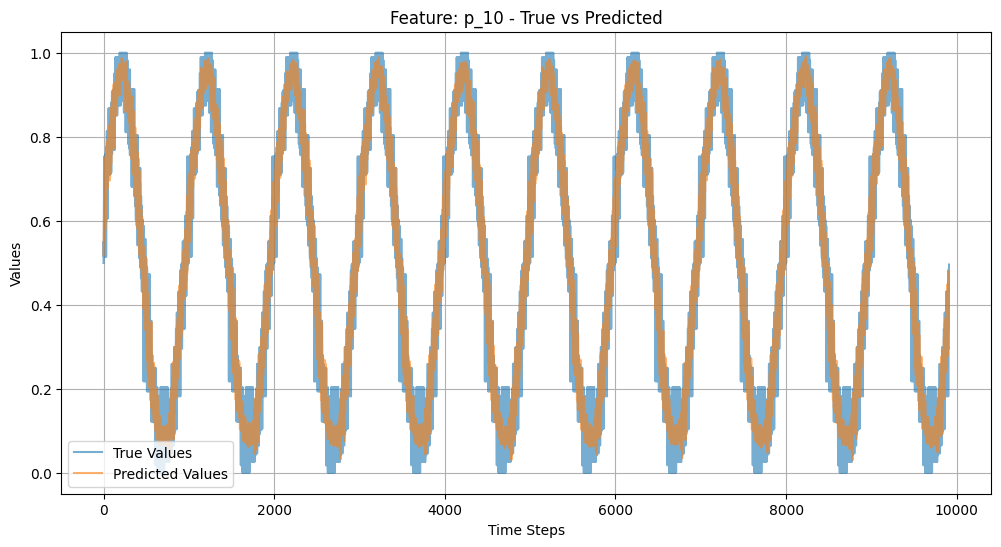

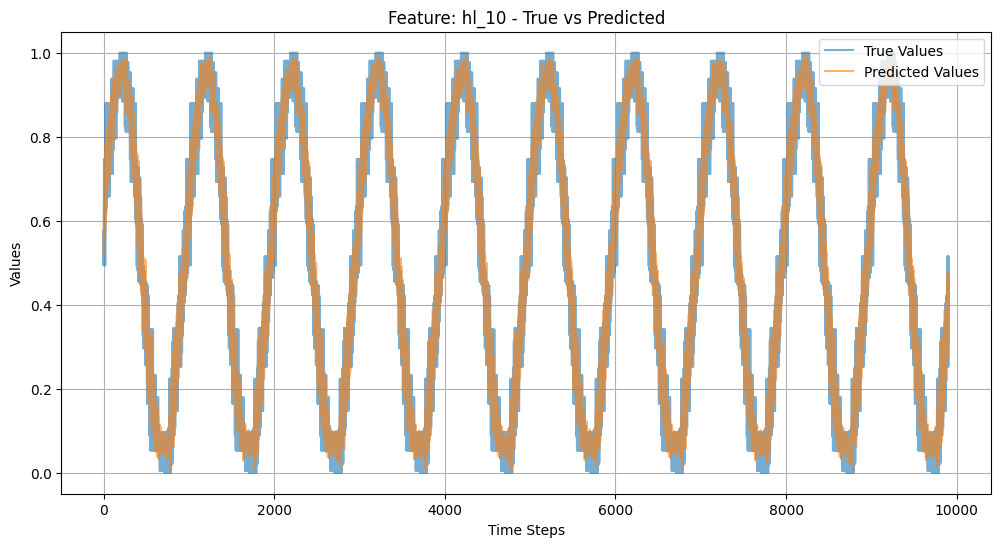

In [27]:
# Plot True Data vs Predicted Data for Each Feature
for feature_index, feature_name in enumerate(features):
    plt.figure(figsize=(12, 6))
    plt.plot(X_time_series_reshaped[:, feature_index], label='True Values', alpha=0.6)
    plt.plot(X_pred_reshaped[:, feature_index], label='Predicted Values', alpha=0.6)
    plt.title(f'Feature: {feature_name} - True vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.show()


# --- ROC Curve for Classification Task ---

# If 'y' would be binary, e.g. {1 or -1}, for ROC; for regression tasks, use MSE/MAE instead
if len(np.unique(y)) == 2:  # Check if it's a binary classification problem
    # Make predictions and calculate probabilities for the ROC curve
    y_pred_proba = best_model.predict(X_time_series).ravel()  # Flatten for ROC
    fpr, tpr, _ = roc_curve(y[:len(y_pred_proba)], y_pred_proba)  # Compute ROC
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()